In [26]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

import draft.data_cleaning as dc

In [14]:
person_1 = pd.read_json(r'datasets/december/liza.json', orient='records', lines=True) # liza
person_2 = pd.read_json(r'datasets/december/sleep_data_Adham.json', lines=True) # adham
person_3 = pd.read_json(r'datasets/december/sleep_data_Miriam.json', lines=True) # miriam
person_4 = pd.read_json(r'datasets/december/sleep_data_Syahid.json', lines=True) # syahid
person_5 = pd.read_json(r'datasets/december/sleep_data_florian.json', lines=True) # florian

# labels dataframe from excel
labels_df = pd.read_excel(r'datasets\sleep_data.xlsx', sheet_name=None) # dict of all label

In [15]:
people_df = [person_1, person_2, person_3, person_4, person_5]

for num, df in enumerate(people_df):
    df.insert(0, "temp_id", num)

In [16]:
# Durchlaufen der Liste und Anwenden der Funktionen
for num, df in enumerate(people_df):
    # Entfernen unverfolgter Nächte
    people_df[num] = dc.delete_untracked_nights(df)

    # Zurücksetzen des Index
    people_df[num].reset_index(drop=True, inplace=True)

# Optional: Zuweisung der bearbeiteten DataFrames zu ihren ursprünglichen Variablennamen
person_1, person_2, person_3, person_4, person_5 = people_df

In [17]:
time_series_list = []

for num, df in enumerate(people_df):
    # Extrahieren der Zeitreihendaten (Annahme: gibt einen DataFrame zurück)
    temp_df = dc.main_interpolation(df)

    # Weisen Sie die eindeutige ID dem DataFrame zu
    temp_df['temp_id'] = num

    # Fügen Sie den aktualisierten DataFrame der neuen Liste hinzu
    time_series_list.append(temp_df)

In [18]:
time_series_list[0][1].shape

(542, 7)

In [19]:
# find total nights
total_nights = 0
# Durchlaufen jeder Person in der Liste
for person_index, person_data in enumerate(time_series_list):
    print(f"Person {person_index + 1}:")

    # Überprüfen, ob person_data ein Dictionary ist
    if isinstance(person_data, dict):
        # Durchlaufen jedes Nacht-DataFrames der Person
        for night, df in person_data.items():
            # Überprüfen, ob der Wert ein DataFrame ist
            if isinstance(df, pd.DataFrame):
                #if len(df) > max_length:
                    #max_length = len(df)
                    print(f"  Nacht {night}: {len(df)} Zeilen")
                    total_nights +=1

print(total_nights)

Person 1:
  Nacht 0: 626 Zeilen
  Nacht 1: 542 Zeilen
  Nacht 2: 428 Zeilen
  Nacht 3: 359 Zeilen
  Nacht 4: 520 Zeilen
  Nacht 5: 413 Zeilen
  Nacht 6: 548 Zeilen
  Nacht 7: 667 Zeilen
  Nacht 8: 428 Zeilen
  Nacht 9: 522 Zeilen
  Nacht 10: 396 Zeilen
  Nacht 11: 541 Zeilen
  Nacht 12: 437 Zeilen
  Nacht 13: 415 Zeilen
  Nacht 14: 552 Zeilen
Person 2:
  Nacht 0: 476 Zeilen
  Nacht 1: 355 Zeilen
  Nacht 2: 344 Zeilen
  Nacht 3: 454 Zeilen
  Nacht 4: 313 Zeilen
  Nacht 5: 529 Zeilen
  Nacht 6: 254 Zeilen
  Nacht 7: 320 Zeilen
  Nacht 8: 600 Zeilen
  Nacht 9: 301 Zeilen
  Nacht 10: 584 Zeilen
  Nacht 11: 384 Zeilen
  Nacht 12: 478 Zeilen
  Nacht 13: 478 Zeilen
  Nacht 14: 434 Zeilen
  Nacht 15: 324 Zeilen
  Nacht 16: 562 Zeilen
  Nacht 17: 505 Zeilen
  Nacht 18: 394 Zeilen
Person 3:
  Nacht 0: 579 Zeilen
  Nacht 1: 313 Zeilen
  Nacht 2: 495 Zeilen
  Nacht 3: 455 Zeilen
  Nacht 4: 547 Zeilen
  Nacht 5: 481 Zeilen
  Nacht 6: 458 Zeilen
  Nacht 7: 524 Zeilen
  Nacht 8: 314 Zeilen
  Nacht 9:

In [21]:
def calculate_maximum_length(list_):
    max_length = 0  # Initialize max_length to store the maximum number of rows

    # Iterate through each person in the list
    for person_index, person_data in enumerate(time_series_list):
        # Iterate through each night DataFrame of the person
        for night, df in person_data.items():
            # Check if the value is a DataFrame
            if isinstance(df, pd.DataFrame):
                # Update max_length if this night has more rows
                if len(df) > max_length:
                    max_length = len(df)

    # After completing the iteration, max_length will hold the number of rows of the longest night
    return max_length

max_length = calculate_maximum_length(time_series_list)
max_length

994

In [27]:
# Define a generator function to yield night DataFrames
def night_generator(time_series_list):
    for person_data in time_series_list:
        for night, df in person_data.items():
            if isinstance(df, pd.DataFrame):
                yield df

# Define a function to process data
def process_data(interpolated_df, max_length):
    padded_data = pad_sequences([interpolated_df.values], dtype='float32', padding='post', maxlen=max_length)
    return padded_data[0]

# Iterate through each person and night to preprocess and pad the data

#Define the maximum length
max_length = calculate_maximum_length(time_series_list)

night_iterator = night_generator(time_series_list)
processed_data = []

for night_df in night_iterator:
    padded_night_data = process_data(night_df, max_length) # do the padding
    processed_data.append(padded_night_data)

# Convert processed data to a NumPy array and normalize if needed
training_data = np.array(processed_data)

# Split  into training/testing sets (80%/20%)
X_train, X_test  = train_test_split(training_data, test_size=0.2, random_state=42)

In [28]:

# Define the number of features per timestep
n_features = 7

# Encoder
inputs = Input(shape=(max_length, n_features))
encoder_lstm = LSTM(100, activation='relu', return_sequences=False)(inputs)
encoder_output = RepeatVector(max_length)(encoder_lstm)

# Decoder
decoder_lstm = LSTM(100, activation='relu', return_sequences=True)(encoder_output)
decoder_output = LSTM(n_features, return_sequences=True)(decoder_lstm)

# Seq2Seq Autoencoder Model
seq2seq_autoencoder = Model(inputs, decoder_output)

# Compile the model
seq2seq_autoencoder.compile(optimizer='adam', loss='mse')

# Show architecture
seq2seq_autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 994, 7)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               43200     
                                                                 
 repeat_vector_2 (RepeatVec  (None, 994, 100)          0         
 tor)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 994, 100)          80400     
                                                                 
 lstm_8 (LSTM)               (None, 994, 7)            3024      
                                                                 
Total params: 126624 (494.62 KB)
Trainable params: 126624 (494.62 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [29]:

# Define the number of epochs and batch size
epochs = 100
batch_size = 32

# Define checkpoints and early stopping
checkpoint = keras.callbacks.ModelCheckpoint('autoencoder_LSTM.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Fit the model to the training data
history = seq2seq_autoencoder.fit(
    X_train,
    X_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[
        checkpoint,
        early_stopping
    ]
)

Epoch 1/100
2/2 [==============================] - 9s 3s/step - loss: 0.0956 - val_loss: 0.0969
Epoch 2/100


c:\Users\ASUS\anaconda3\envs\AdvIntSys\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 5s 2s/step - loss: 0.0938 - val_loss: 0.0949
Epoch 3/100
2/2 [==============================] - 4s 2s/step - loss: 0.0917 - val_loss: 0.0922
Epoch 4/100
2/2 [==============================] - 5s 2s/step - loss: 0.0889 - val_loss: 0.0888
Epoch 5/100
2/2 [==============================] - 5s 2s/step - loss: 0.0854 - val_loss: 0.0845
Epoch 6/100
2/2 [==============================] - 5s 2s/step - loss: 0.0810 - val_loss: 0.0793
Epoch 7/100
2/2 [==============================] - 5s 2s/step - loss: 0.0757 - val_loss: 0.0737
Epoch 8/100
2/2 [==============================] - 5s 2s/step - loss: 0.0716 - val_loss: 0.0722
Epoch 9/100
2/2 [==============================] - 5s 2s/step - loss: 0.0712 - val_loss: 0.0700
Epoch 10/100
2/2 [==============================] - 5s 2s/step - loss: 0.0689 - val_loss: 0.0671
Epoch 11/100
2/2 [==============================] - 5s 2s/step - loss: 0.0664 - val_loss: 0.0658
Epoch 12/100
2/2 [==============================] 

Autoencoder visualization

1/1 [==============================] - 1s 654ms/step


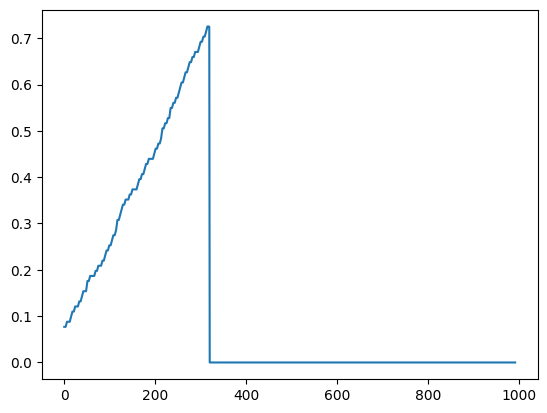

In [33]:
from matplotlib import pyplot as plt

X_test_recon = seq2seq_autoencoder.predict(X_test)

# 1st day in X_test, all values for the last feature
plt.plot(X_test[1,:-1,5])
plt.show()

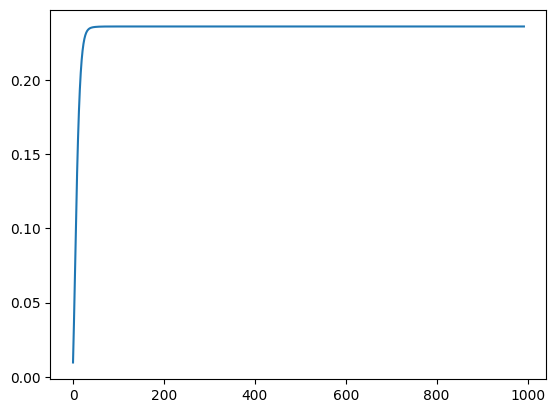

In [35]:
# 1st day in X_test_recon, all values for the second last feature
plt.plot(X_test_recon[1,:-1,5])
plt.show()

In [34]:
# Assuming your encoder LSTM layer is named 'encoder_lstm'

# Step 1: Extract the Encoder Model
# This model takes the same inputs as your seq2seq_autoencoder but outputs the encoder's state
encoder_model = Model(inputs=seq2seq_autoencoder.input, outputs=seq2seq_autoencoder.get_layer(index=2).output)
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 994, 7)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 100)               43200     
                                                                 
 repeat_vector_2 (RepeatVec  (None, 994, 100)          0         
 tor)                                                            
                                                                 
Total params: 43200 (168.75 KB)
Trainable params: 43200 (168.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Encoder-only visualization

In [36]:
# Define function to save embeddings
def save_embeddings(model, x_data, save_path='embeddings.npy'):
    embeddings = model.predict(x_data)
    np.save(save_path, embeddings)
    print(f'Embeddings saved to {save_path}')

In [37]:
save_embeddings(encoder_model,X_test,save_path="X_test_embeddings.npy")
X_test_embeddings = np.load("X_test_embeddings.npy")

1/1 [==============================] - 0s 437ms/step
Embeddings saved to X_test_embeddings.npy


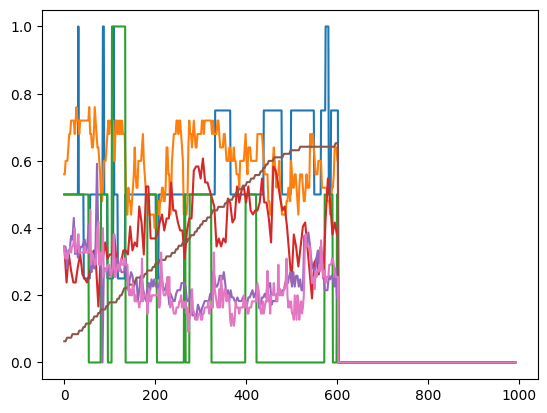

In [38]:
plt.plot(X_test[2][:-1])
plt.show()

In [39]:
X_test.shape

(19, 994, 7)

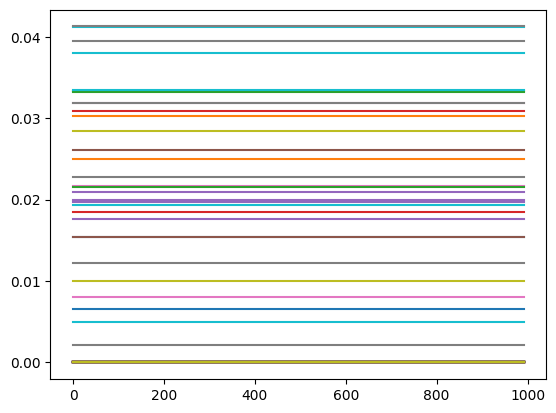

In [40]:
plt.plot(X_test_embeddings[2][:-1])
plt.show()

In [41]:
X_test_embeddings.shape

(19, 994, 100)

In [119]:
# Step 2: Use the Encoder for Prediction
# padding the input
padded = process_data(time_series_list[0][0], max_length=max_length)
arr = np.array(padded)
data_reshaped = np.expand_dims(arr, axis=0)

# get the embeddings
encoder_model.predict(data_reshaped)

1/1 [==============================] - 0s 369ms/step


array([[0.        , 0.03929291, 0.        , 0.05729467, 0.05546304,
        0.        , 0.00956762, 0.        , 0.02829745, 0.02150617,
        0.00673084, 0.05754669, 0.        , 0.03195135, 0.01586103,
        0.01334444, 0.0274994 , 0.        , 0.        , 0.        ,
        0.06037556, 0.00967422, 0.        , 0.0394587 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01515129,
        0.        , 0.        , 0.        , 0.        , 0.01892987,
        0.        , 0.        , 0.05186971, 0.03989829, 0.        ,
        0.        , 0.        , 0.00200168, 0.        , 0.        ,
        0.04898386, 0.03667377, 0.02549991, 0.        , 0.        ,
        0.02723131, 0.01746187, 0.        , 0.05198036, 0.03288264,
        0.        , 0.        , 0.01830428, 0.04225369, 0.        ,
        0.05542608, 0.0306214 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01962096, 0.        ,
        0.        , 0.        , 0.        , 0.02

In [120]:
data_reshaped.shape

(1, 994, 7)